# 集成投票分類(Ensemble Voting Classifier)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Training Data

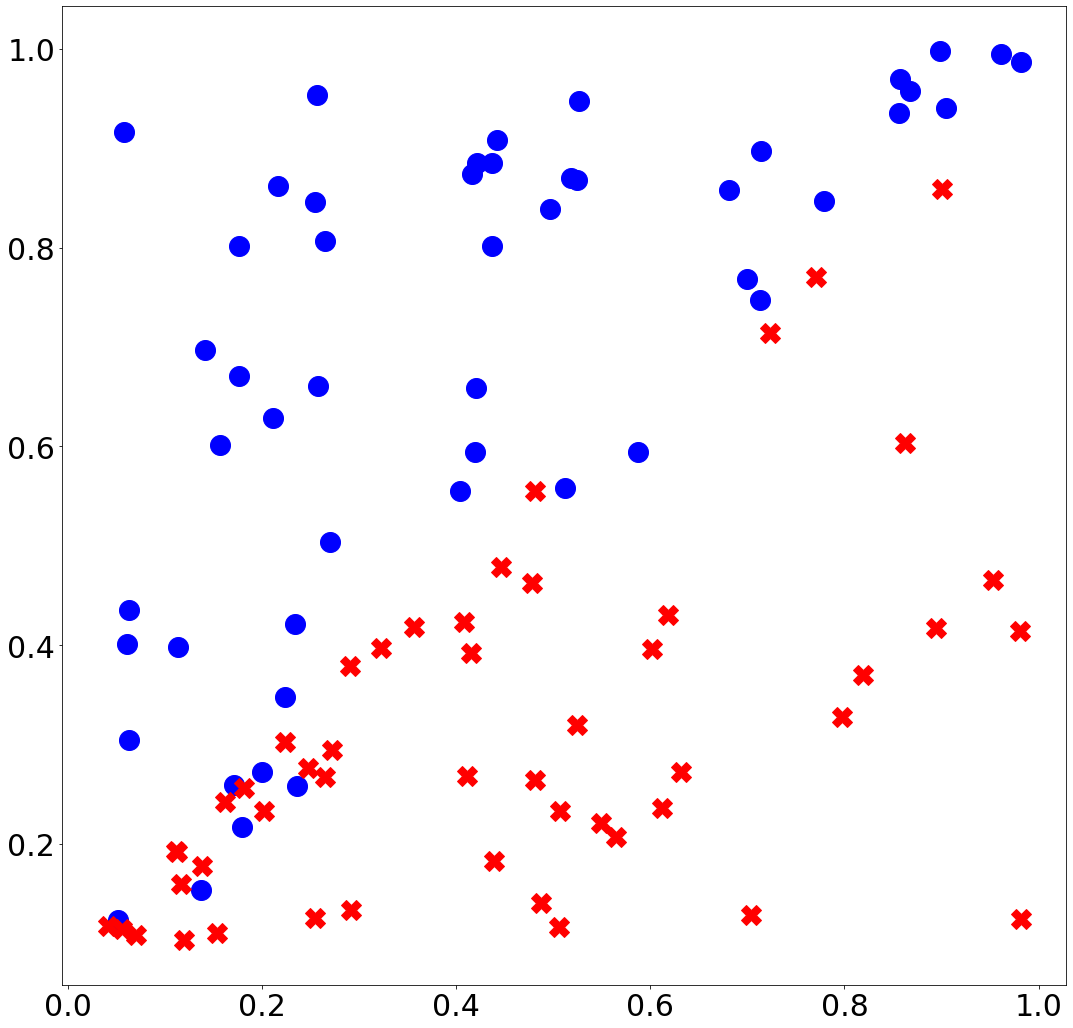

In [2]:
x=np.zeros((100,2))
y=np.zeros(100)
for i in range(0,100): 
    f=-0.1
    if(i<50):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:50,0],x[:50,1],"bo",markersize=20)
plt.plot(x[50:,0],x[50:,1],"rX",markersize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=20
x_test=np.zeros((N_test,2))
y_test=np.zeros(N_test)
for i in range(0,N_test): 
    f=-0.1
    if(i<N_test/2):
        y_test[i]=1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(x_test[i,0],1)
    else:
        y_test[i]=-1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(0,x_test[i,0])-f

# Polynomial Kernel

In [4]:
def Polynomial_kernel(x,xx,power,gamma,zeta):
    return (zeta+gamma*np.dot(x,xx.T))**power

# Perceptron Learning Algorithms

In [5]:
def PLA(x,y,c,gamma,zeta,N):
    a=np.ones(N)
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    b=0
    nn=max((x[:,0]**2)+(x[:,0]**2))
    for i in range(0,1000):
        check=np.sign(np.dot(K,y*a)+b)==y
        i=random.randint(0,N-1)
        if(check[i]==False):
            a[i]+=1
            b+=y[i]*nn
    return a,b

# Kernel Logistic Regression

In [6]:
def KLR(x,y,c,gamma,zeta,N):
    s=0.01
    lambda_2=0.1
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    a=np.zeros(N)
    for i in range(0,50000):
        A=(2*lambda_2/N)*np.dot(K,a)
        B=np.dot(K/np.outer(np.ones(N)+np.exp(-np.dot(K,a)),np.ones(N)).T,np.ones(N)-y)/N
        C=np.dot(K/np.outer(np.ones(N)+np.exp(np.dot(K,a)),np.ones(N)).T,-y)/N
        D=(2*lambda_2/N)*np.diagonal(K)
        E=np.dot((K**2)/np.outer(2*np.ones(N)+np.exp(np.dot(K,a))+np.exp(-np.dot(K,a)),np.ones(N)).T,np.ones(N))/N
        a=a-s*(A+B+C)/(D+E)
    return a

# Support Vector Machine

In [7]:
def SVM(x,y,c,CC,gamma,zeta,N):
    Q = cvxopt.matrix((np.outer(y,y) * Polynomial_kernel(x,x,c,gamma,zeta)))
    p = cvxopt.matrix(np.ones(N)*-1.,(N,1))
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(N)* 1.),np.diag(np.ones(N)* -1.)])) 
    h = cvxopt.matrix(np.concatenate([CC*np.ones(N),np.zeros(N)]))
    A = cvxopt.matrix(y,(1,N))
    b = cvxopt.matrix(0.0)
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    a=np.array(cvxopt.solvers.qp(Q, p, G, h, A, b)['x']).flatten()
    SV=[]
    for i in range(0,N):
        if(a[i]>1e-6):
            SV.append(i)
    for sv in SV:
        if(y[sv]==1):
            s_u=sv
            break
    Com=0
    for i in range(0,N):
        Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s_u,:],c,gamma,zeta)
    b_u=y[s_u]-Com
    for sv in SV:
        if(y[sv]==-1):
            s_l=sv
            break
    Com=0
    for i in range(0,N):
        Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s_l,:],c,gamma,zeta)
    b_l=y[s_l]-Com
    return a,(b_u+b_l)/2

# Platt Scaling

In [8]:
def Platt(x,y,a,b,c,gamma,zeta):
    # N_pos: label為1的資料數量
    # N_neg: label為-1的資料數量
    N_pos=len(y[y==y[0]])
    N_neg=len(y)-N_pos
    N=len(y)
    # f(x)
    f=np.dot(Polynomial_kernel(x,x,c,gamma,zeta),a*y)+b
    # 擬合參數
    A,B=0,0
    # learning rate
    r=0.1
    # 迭代次數
    STEP=1000
    for i in range(0,STEP):
        # seed對應到標記資料
        seed=(y==y[0])
        # 這裡可對照文章的公式
        dA_pos=sum(((N_pos+1)/(N_pos+2))*(f[seed]/(1+np.exp(-A*f[seed]-B)))-(1/(N_pos+2))*(f[seed]/(1+np.exp(A*f[seed]+B))))
        dB_pos=sum(((N_pos+1)/(N_pos+2))*(1/(1+np.exp(-A*f[seed]-B)))-(1/(N_pos+2))*(1/(1+np.exp(A*f[seed]+B))))
        dA_neg=sum((1/(N_neg+2))*(f[~seed]/(1+np.exp(-A*f[~seed]-B)))-((N_neg+1)/(N_neg+2))*(f[~seed]/(1+np.exp(A*f[~seed]+B))))
        dB_neg=sum((1/(N_neg+2))*(1/(1+np.exp(-A*f[~seed]-B)))-((N_neg+1)/(N_neg+2))*(1/(1+np.exp(A*f[~seed]+B))))
        A=A-r*(dA_pos+dA_neg)/N
        B=B-r*(dB_pos+dB_neg)/N
    # 回傳y==1的機率和A、B擬合參數
    return 1/(1+np.exp(A*f+B)),A,B

# SVM vs PLA vs KLR

In [9]:
c=5
CC=100
gamma,zeta=1,1
N=100
K=Polynomial_kernel(x,x,c,gamma,zeta)
K_test=Polynomial_kernel(x_test,x,c,gamma,zeta)

a_SVM,b_SVM=SVM(x,y,c,CC,gamma,zeta,N)
p_SVM,A_SVM,B_SVM=Platt(x,y,a_SVM,b_SVM,c,gamma,zeta)
print("the SVM traning error",round(1-len(y[np.sign(np.dot(K,a_SVM*y)+b_SVM)==y])/N,2),
     "testing error", round(1-len(y_test[np.sign(np.dot(K_test,a_SVM*y)+b_SVM)==y_test])/N_test,2))

a_PLA,b_PLA=PLA(x,y,c,gamma,zeta,N)
p_PLA,A_PLA,B_PLA=Platt(x,y,a_PLA,b_PLA,c,gamma,zeta)
print("the PLA traning error",round(1-len(y[np.sign(np.dot(K,a_PLA*y)+b_PLA)==y])/N,2),
     "testing error", round(1-len(y_test[np.sign(np.dot(K_test,a_PLA*y)+b_PLA)==y_test])/N_test,2))

logit_y=np.zeros(N)
logit_y[y==1]=np.ones(50)
a_KLR=KLR(x,logit_y,c,gamma,zeta,N)
p_KLR=1/(1+np.exp(-np.dot(Polynomial_kernel(x,x,c,gamma,zeta),a_KLR)))
print("the KLR traning error",round(1-len(y[np.sign(np.dot(K,a_KLR))==y])/N,2),
     "testing error", round(1-len(y_test[np.sign(np.dot(K_test,a_KLR))==y_test])/N_test,2))

the SVM traning error 0.1 testing error 0.05
the PLA traning error 0.19 testing error 0.2
the KLR traning error 0.1 testing error 0.1


# Hard Voting

In [10]:
# 存放判別機率大於0.5的矩陣
BOOL=np.ones((3,N), dtype=bool)
# 當label為1，如果對應的機率>0.5為True反之為False
# 當label為-1，如果對應的機率<0.5為True反之為False
BOOL[0,y==1],BOOL[1,y==1],BOOL[2,y==1]=p_SVM[y==1]>0.5,p_PLA[y==1]>0.5,p_KLR[y==1]>0.5
BOOL[0,y==-1],BOOL[1,y==-1],BOOL[2,y==-1]=p_SVM[y==-1]<0.5,p_PLA[y==-1]<0.5,p_KLR[y==-1]<0.5
# 計算分類錯誤率
MIX_train_err=round(1-sum(sum(BOOL)>3/2)/N,2)
# 測試集
p_SVM_test=1/(1+np.exp(A_SVM*(np.dot(K_test,a_SVM*y)+b_SVM)+B_SVM))
p_PLA_test=1/(1+np.exp(A_PLA*(np.dot(K_test,a_PLA*y)+b_PLA)+B_PLA))
p_KLR_test=1/(1+np.exp(-np.dot(K_test,a_KLR)))
# 用一樣的方式計算測試錯誤率
BOOL_test=np.ones((3,N_test), dtype=bool)
BOOL_test[0,y_test==1],BOOL_test[0,y_test==-1]=p_SVM_test[y_test==1]>0.5,p_SVM_test[y_test==-1]<0.5
BOOL_test[1,y_test==1],BOOL_test[1,y_test==-1]=p_PLA_test[y_test==1]>0.5,p_PLA_test[y_test==-1]<0.5
BOOL_test[2,y_test==1],BOOL_test[2,y_test==-1]=p_KLR_test[y_test==1]>0.5,p_KLR_test[y_test==-1]<0.5
MIX_test_err=round(1-sum(sum(BOOL_test)>3/2)/N_test,2)
print("the Ensemble Hard-Voting traning error",MIX_train_err,"testing error", MIX_test_err)

the Ensemble Hard-Voting traning error 0.1 testing error 0.05


# Soft Voting

In [11]:
# 把所有model機率加起來除以model數量
# 然後以相同的方法計算錯誤率
p_MIX=(p_SVM+p_PLA+p_KLR)/3
p_MIX_test=(p_SVM_test+p_PLA_test+p_KLR_test)/3
MIX_train_err=round(1-(sum(p_MIX[y==1]>0.5)+sum(p_MIX[y==-1]<0.5))/N,2)
MIX_test_err=round(1-(sum(p_MIX_test[y_test==1]>0.5)+sum(p_MIX_test[y_test==-1]<0.5))/N_test,2)
print("the Ensemble Soft-Voting traning error",MIX_train_err,"testing error", MIX_test_err)

the Ensemble Soft-Voting traning error 0.1 testing error 0.05
